# Análisis de tiempos por escenario (JADE vs SPADE)

Este cuaderno busca y carga automáticamente el último archivo JSON por escenario para:
- **JADE** desde `JADE_Output/IterationResults/<escenario>/*.json` (duración en milisegundos)
- **SPADE** desde `SPADE_Output/results_json_profiling/<escenario>/*.json` (duración en segundos)

Se normaliza la duración a segundos (JADE ÷ 1000, SPADE tal cual), se arma una tabla comparativa y se generan gráficos.


In [14]:
from __future__ import annotations
import json
import math
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

BASE = Path('.').resolve()

JADE_BASE = BASE / 'JADE_Output' / 'IterationResults'
SPADE_BASE = BASE / 'SPADE_Output' / 'results_json_profiling'

SCENARIOS = ['small', 'medium', 'full']

JADE_GLOB = 'iteration_log_*.json'
SPADE_GLOB = 'iteration_results_*.json'


def list_json_files(base: Path, scenario: str, pattern: str) -> List[Path]:
    scen_dir = base / scenario
    if not scen_dir.exists():
        return []
    files = sorted([p for p in scen_dir.glob(pattern) if p.is_file()])
    return files


def pick_latest_by_timestamp(files: List[Path]) -> Optional[Path]:
    if not files:
        return None
    # Use file modified time as a robust fallback
    return max(files, key=lambda p: p.stat().st_mtime)


def read_first_duration_from_json_array(path: Path) -> Optional[float]:
    try:
        with path.open('r', encoding='utf-8') as f:
            data = json.load(f)
        # Expect either list with an object or object
        if isinstance(data, list) and data:
            item = data[0]
        elif isinstance(data, dict):
            item = data
        else:
            return None
        # SPADE uses seconds float; JADE seems to use microseconds (ints ~ 1,000,000)
        # Try known keys
        for key in ['duration', 'Duration', 'time', 'elapsed', 'elapsed_time']:
            if key in item and isinstance(item[key], (int, float)):
                return float(item[key])
        return None
    except Exception:
        return None


def normalize_duration_seconds(value: float, source: str) -> float:
    # Normalize by source: JADE = milliseconds, SPADE = seconds
    if value is None or (isinstance(value, float) and math.isnan(value)):
        return np.nan
    if source.upper() == 'JADE':
        return float(value) / 1_000.0
    # SPADE already in seconds
    return float(value)


def collect_latest_durations() -> pd.DataFrame:
    records: List[Dict[str, object]] = []

    for scenario in SCENARIOS:
        # JADE
        jade_files = list_json_files(JADE_BASE, scenario, JADE_GLOB)
        jade_jsons = [p for p in jade_files if p.suffix == '.json']
        jade_latest = pick_latest_by_timestamp(jade_jsons)
        jade_duration_raw: Optional[float] = read_first_duration_from_json_array(jade_latest) if jade_latest else None
        jade_duration_sec = normalize_duration_seconds(jade_duration_raw, 'JADE') if jade_duration_raw is not None else np.nan

        # SPADE
        spade_files = list_json_files(SPADE_BASE, scenario, SPADE_GLOB)
        spade_jsons = [p for p in spade_files if p.suffix == '.json']
        spade_latest = pick_latest_by_timestamp(spade_jsons)
        spade_duration_raw: Optional[float] = read_first_duration_from_json_array(spade_latest) if spade_latest else None
        spade_duration_sec = normalize_duration_seconds(spade_duration_raw, 'SPADE') if spade_duration_raw is not None else np.nan

        records.append({
            'scenario': scenario,
            'jade_file': str(jade_latest) if jade_latest else None,
            'spade_file': str(spade_latest) if spade_latest else None,
            'jade_duration_s': jade_duration_sec,
            'spade_duration_s': spade_duration_sec,
        })

    df = pd.DataFrame.from_records(records)
    return df


df = collect_latest_durations()
df


,scenario,jade_file,spade_file,jade_duration_s,spade_duration_s
0,small,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,11.408,5.199340
1,medium,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,18.462,20.225291
2,full,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,23.675,35.260620


In [15]:
# Vista básica
print('Archivos detectados:')
for _, row in df.iterrows():
    print(f"- {row['scenario']}: JADE={row['jade_file']} | SPADE={row['spade_file']}")

# Tabla ordenada
(df
 .assign(jade_vs_spade_ratio=lambda x: x['jade_duration_s'] / x['spade_duration_s'])
 .sort_values('scenario')
)


Archivos detectados:
- small: JADE=C:\Users\fccod\OneDrive\Documentos\GitHub\Work\Francoo86\MultiAgent-Benchmark\JADE_Output\IterationResults\small\iteration_log_20250903_032339.json | SPADE=C:\Users\fccod\OneDrive\Documentos\GitHub\Work\Francoo86\MultiAgent-Benchmark\SPADE_Output\results_json_profiling\small\iteration_results_20250619_144117.json
- medium: JADE=C:\Users\fccod\OneDrive\Documentos\GitHub\Work\Francoo86\MultiAgent-Benchmark\JADE_Output\IterationResults\medium\iteration_log_20250724_135958.json | SPADE=C:\Users\fccod\OneDrive\Documentos\GitHub\Work\Francoo86\MultiAgent-Benchmark\SPADE_Output\results_json_profiling\medium\iteration_results_20250619_144428.json
- full: JADE=C:\Users\fccod\OneDrive\Documentos\GitHub\Work\Francoo86\MultiAgent-Benchmark\JADE_Output\IterationResults\full\iteration_log_20250724_141207.json | SPADE=C:\Users\fccod\OneDrive\Documentos\GitHub\Work\Francoo86\MultiAgent-Benchmark\SPADE_Output\results_json_profiling\full\iteration_results_20250619_1445

,scenario,jade_file,spade_file,jade_duration_s,spade_duration_s,jade_vs_spade_ratio
2,full,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,23.675,35.260620,0.671429
1,medium,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,18.462,20.225291,0.912818
0,small,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,C:\Users\fccod\OneDrive\Documentos\GitHub\Work...,11.408,5.199340,2.194124


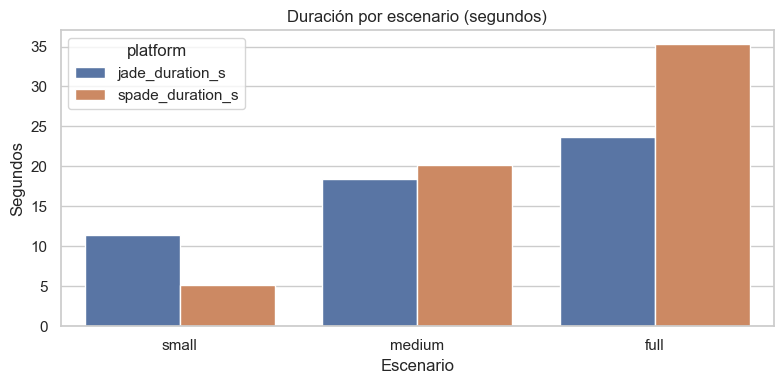

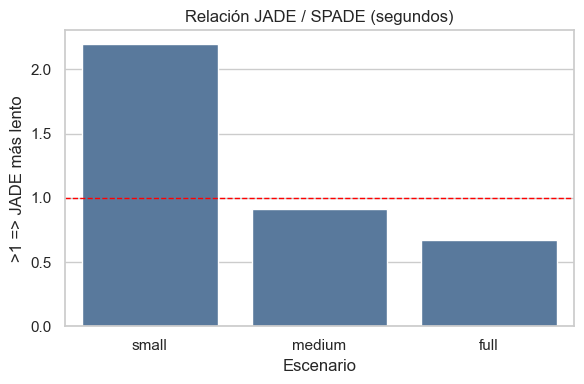

In [16]:
# Gráficos comparativos
sns.set(style='whitegrid')

melted = df.melt(id_vars=['scenario'], value_vars=['jade_duration_s', 'spade_duration_s'],
                 var_name='platform', value_name='duration_s')

plt.figure(figsize=(8,4))
sns.barplot(data=melted, x='scenario', y='duration_s', hue='platform')
plt.title('Duración por escenario (segundos)')
plt.ylabel('Segundos')
plt.xlabel('Escenario')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
ratio = (df
         .assign(ratio=df['jade_duration_s'] / df['spade_duration_s'])
         .loc[:, ['scenario', 'ratio']])
sns.barplot(data=ratio, x='scenario', y='ratio', color='#4e79a7')
plt.axhline(1.0, ls='--', c='red', lw=1)
plt.title('Relación JADE / SPADE (segundos)')
plt.ylabel('>1 => JADE más lento')
plt.xlabel('Escenario')
plt.tight_layout()
plt.show()
